# Assignment 3: Unsupervised learning for red wine characteristics
Machine Learning for the Social Sciences
Prof. Michael Parrot
19 November 2021
Yun Choi

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import all models we will use
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

In [2]:
# Read red wine data
df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 1. Use K Means Cluster Analysis to identify cluster(s) of observations that have high and low values of the wine quality. (Assume all variables are continuous.) Describe variables that cluster with higher values of wine quality. Describe variables that cluster with lower values of wine quality. If you want to make a good bottle of wine, then what characteristics are most important according to this analysis?

In [3]:
# Scale data
X=pd.DataFrame(scale(df), index=df.index, columns=df.columns)
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.787823
1,-0.298547,1.967442,-1.391472,0.043416,0.223875,0.872638,0.624363,0.028261,-0.719933,0.128950,-0.584777,-0.787823
2,-0.298547,1.297065,-1.186070,-0.169427,0.096353,-0.083669,0.229047,0.134264,-0.331177,-0.048089,-0.584777,-0.787823
3,1.654856,-1.384443,1.484154,-0.453218,-0.264960,0.107592,0.411500,0.664277,-0.979104,-0.461180,-0.584777,0.450848
4,-0.528360,0.961877,-1.391472,-0.453218,-0.243707,-0.466193,-0.379133,0.558274,1.288643,-0.579207,-0.960246,-0.787823


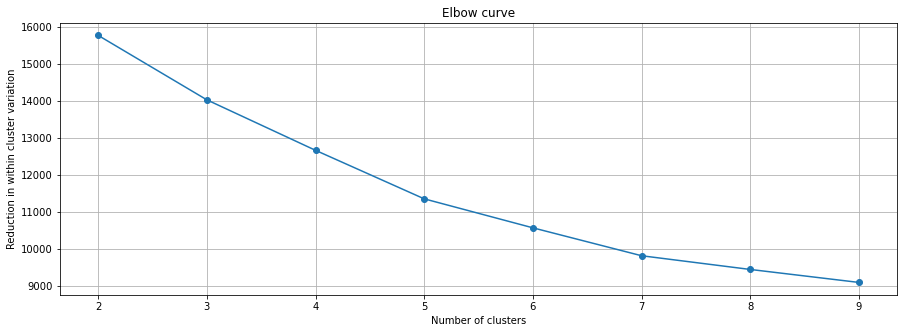

In [4]:
# Create an elbow chart to determine the optimal number of clusters
# Initiate empty list with no data
within_cluster_variance = []

# build models for range of ks from 2 to 10
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    within_cluster_variance.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), within_cluster_variance, marker='o')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Reduction in within cluster variation')
plt.title('Elbow curve');

The elbow chart above shows that the magnitude of within-cluster variation reduction drastically decreases as the number of clusters reaches seven. So I have decided to group wines into seven clusters.

In [5]:
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(X)
X['cluster'] = kmeans.labels_
# Show the mean values of each column for each
df_2 = X.groupby('cluster').mean().sort_values('quality', ascending=False)
print(df_2)

         fixed acidity  volatile acidity  citric acid  residual sugar  \
cluster                                                                 
2             0.194068         -1.007902     0.720717       -0.109011   
6            -1.066777          0.395514    -0.932008       -0.239024   
0             1.662733         -0.581050     1.250385        0.129240   
4            -0.085633         -0.034652     0.414856        4.961768   
5             0.081831          0.017955     1.144178       -0.399396   
3            -0.119049          0.020357     0.059254       -0.022704   
1            -0.407518          0.646368    -0.756594       -0.213623   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
cluster                                                                   
2        -0.286380            -0.313407             -0.538780 -0.568067   
6        -0.402907             0.240109             -0.193204 -1.292710   
0         0.076985            -0.497427   

The table above shows the mean values of all variables for each cluster, sorted by 'quality' in descending order. The table shows that variables are not equally associated with quality. Some variables - 'volatile acidity', 'total_sulfur_dioxide', 'density', and 'high alcohol', for example - have a stronger association than others. When the wine quality increases, they consistently increase or decrease.

The characteristics strongly associated with high-quality wines seem to be:
- low volatile acidity
- low total sulfur dioxide
- low density
- high alcohol

The characteristics strongly associated with low-quality wines seem to be:
- high volatile acidity
- high total sulfur dioxide
- high density
- low alcohol

However, by looking at the mean values with the naked eye, it is hard to tell which variables are more important than others by how much.

In [6]:
for c in list(df_2.columns)[0:11]:
    corr, _ = pearsonr(df_2[c], df_2['quality'])
    print("Pearsons correlation b/w", c, "and quality: %.3f" % corr)

Pearsons correlation b/w fixed acidity and quality: 0.066
Pearsons correlation b/w volatile acidity and quality: -0.679
Pearsons correlation b/w citric acid and quality: 0.126
Pearsons correlation b/w residual sugar and quality: -0.040
Pearsons correlation b/w chlorides and quality: -0.373
Pearsons correlation b/w free sulfur dioxide and quality: -0.192
Pearsons correlation b/w total sulfur dioxide and quality: -0.439
Pearsons correlation b/w density and quality: -0.418
Pearsons correlation b/w pH and quality: 0.243
Pearsons correlation b/w sulphates and quality: -0.160
Pearsons correlation b/w alcohol and quality: 0.905


I calculate the Pearson correlation coefficient between each variable and 'quality' to see the strength of each correlation. The Pearson correlation coefficient returns a value between -1 and 1 that represents the limits of correlation from a full negative correlation to a full positive correlation. A value of 0 means no correlation.

The coefficients above show that 'alcohol', 'volatile acidity', 'total sulfur dioxide', and 'density' are most strongly correlated with quality, in that order, although the direction varies by variables. 'Alcohol' is positively correlated with quality, while the others are negatively correlated, as shown from the signals of their correlation coefficients.

Pearson correlation coefficients:
- Alcohol and quality: 0.905
- Volatile acidity and quality: -0.679
- Total sulfur dioxide and quality: -0.439
- Density and quality: -0.418

The results align with the expectation I had above based on the mean values of variables per cluster, but they provide a clearer picture of which variables are more strongly correlated than others by how much. Based on these results, we can conclude that having high alcohol, low volatile acidity, low total sulfur dioxide, and low density are essential for wine to be high quality.

## 2. Use Hierarchical Cluster Analysis to identify cluster(s) of observations that have high and low values of the wine quality. (Assume all variables are continuous.) Use complete linkage and the same number of groups that you found to be the most meaningful in question 1. Describe variables that cluster with higher values of wine quality. Describe variables that cluster with lower values of wine quality. If you want to make a good bottle of wine, then what characteristics are most important according to this analysis? Have your conclusions changed using Hierarchical clustering rather than k means clustering? Present any figures that assist you in your analysis.

In [7]:
# Refresh the data
X=pd.DataFrame(scale(df), index=df.index, columns=df.columns)
# Create a distance matrix for hierarchical clustering
row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')

In [8]:
from sklearn.cluster import AgglomerativeClustering
np.random.RandomState(42)
ac = AgglomerativeClustering(n_clusters=7,
                             affinity='euclidean',
                             linkage='complete')
X['cluster'] = ac.fit_predict(X)
# Show the mean values of each column for each
df_2 = X.groupby('cluster').mean().sort_values('quality', ascending=False)
print(df_2)

         fixed acidity  volatile acidity  citric acid  residual sugar  \
cluster                                                                 
4            -0.624115         -1.291336     1.364336        5.293553   
5             2.482856         -0.657106     1.592896        0.192963   
0            -1.097587          0.430947    -0.721546       -0.283762   
6             0.284822         -0.598039     0.630946        6.832574   
2             0.009946         -0.002846    -0.029360       -0.042682   
1             0.012429         -0.100884     0.528057       -0.328215   
3             0.074897         -0.350945     3.127368        0.043416   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
cluster                                                                   
4        -0.675866             3.167777              5.956069 -1.185471   
5        -0.056174            -0.471818             -0.452472  1.468131   
0        -0.402129            -0.181139   

The table above shows the mean values of all variables for each cluster, sorted by 'quality' in descending order. The table again shows that variables are not equally associated with quality. Here, 'alcohol', 'sulphates', and 'chlorides' seems to have a stronger association with 'quality' than the other variables. When the wine quality increases, they consistently increases or decreases.

The characteristics strongly associated with high-quality wines seem to be:
- high alcohol
- low sulphates
- low chlorides

The characteristics strongly associated with low-quality wines seem to be:
- low alcohol
- high sulphates
- high chlorides

However, by looking at the mean values with the naked eye, it is hard to tell which variables are more important than others by how much.

In [9]:
for c in list(df_2.columns)[0:11]:
    corr, _ = pearsonr(df_2[c], df_2['quality'])
    print("Pearsons correlation b/w", c, "and quality: %.3f" % corr)

Pearsons correlation b/w fixed acidity and quality: 0.093
Pearsons correlation b/w volatile acidity and quality: -0.499
Pearsons correlation b/w citric acid and quality: -0.356
Pearsons correlation b/w residual sugar and quality: 0.439
Pearsons correlation b/w chlorides and quality: -0.863
Pearsons correlation b/w free sulfur dioxide and quality: 0.484
Pearsons correlation b/w total sulfur dioxide and quality: 0.564
Pearsons correlation b/w density and quality: -0.299
Pearsons correlation b/w pH and quality: 0.311
Pearsons correlation b/w sulphates and quality: -0.869
Pearsons correlation b/w alcohol and quality: 0.697


The Pearson correlation coefficients above show that 'sulphates', 'chlorides', 'alcohol', and 'volatile acidity' are most strongly correlated with 'quality', in that order. 'Alcohol' is positively correlated with quality, while the others are negatively correlated, as shown by the signals of the correlation coefficients.

Pearson correlation coefficients:
- Sulphates and quality: 0.869
- Chlorides and quality: -0.863
- Alcohol and quality: -0.697
- Volatile acidity and quality: -0.499

The result from Agglomerative Clustering vastly differs from that from K-means Clustering. The result from K-means Clustering is that 'alcohol', 'volatile acidity', 'total sulfur dioxide', and 'density' are most strongly correlated with quality, in that order, while that from Agglomerative Clustering is that 'sulphates', 'chlorides', 'alcohol', and 'volatile acidity' are most strongly correlated with quality, in that order. Such a disparity implies that clustering results can change significantly depending on which algorithm you choose.


## 3. Use Principal Components Analysis to reduce the dimensions of your data. How much of the variation in your data is explained by the first two principal components? How might you use the first two components to do supervised learning on some other variable tied to wine (e.g. - wine price)?

In [10]:
# Reset data
X=pd.DataFrame(scale(df), index=df.index, columns=df.columns)
X_pca = PCA(n_components=4, random_state=42)
X_pca.fit(X)
print(X_pca.explained_variance_ratio_)

[0.26009731 0.1868235  0.14024331 0.10125174]


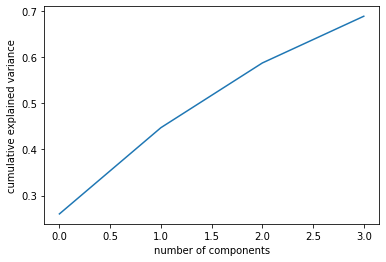

In [11]:
plt.plot(np.cumsum(X_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

The table and chart above show that the first and second principal components explain 26% and 17% of variance in the red wine dataset, respectively. In total, they explain 43% of variance.

In [14]:
# The loading vectors
pca_loadings = pd.DataFrame(X_pca.fit(X).components_.T, index=X.columns, columns=['V1', 'V2', 'V3', 'V4'])
pca_loadings.sort_values('V1', ascending=False)

,V1,V2,V3,V4
fixed acidity,0.487883,-0.004173,-0.164829,-0.231098
citric acid,0.473335,-0.137358,0.100229,-0.056736
density,0.370301,0.330781,-0.168723,-0.200693
sulphates,0.254535,-0.109334,0.212913,0.560502
chlorides,0.197427,0.189788,-0.026608,0.654778
residual sugar,0.139154,0.167736,0.243620,-0.383038
quality,0.112489,-0.473166,0.223369,-0.036669
total sulfur dioxide,0.004067,0.363971,0.540732,-0.028460
free sulfur dioxide,-0.045881,0.259483,0.616111,-0.033711
alcohol,-0.073177,-0.502709,0.224971,-0.091701


The table above shows the coefficients in the first two principal components. The larger the absolute value of the coefficient, the more important the corresponding variable is in calculating the component.

The first principal component has large positive associations with 'fixed acidity(.49)', and 'citric acid(.47)', while the second component has large negative associations with 'quality(-.47)' and 'alcohol(-.5)'. This result implies that wines in the dataset mostly vary in acidity and quality.

I believe these two components will be useful in predicting the type of grapes used in wine, and the price of wine. Acidity is mostly derived naturally from the grapes themselves, so the large variance in acidity will help predict the type of grapes the wine is made of. Quality is presumably one of the decisive factors in deciding the price of wine, so the large variance in quality will help predict the price.